In [ ]:
import tkinter as tk
from tkinter import filedialog

root = tk.Tk()
root.withdraw()
file_path = filedialog.askopenfilename()
print("Ausgewählte Datei:", file_path)


In [ ]:
import json

with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

print(data)  # Gibt den Inhalt als Dictionary aus

{'PartNr': 'WEI.2428510000', 'Graphic3d': {'Points': [{'X': 3.58, 'Y': 15.6872139, 'Z': 30.9803848}, {'X': 3.221253, 'Y': 15.4067707, 'Z': 35.6303864}, {'X': 3.58, 'Y': 15.6872139, 'Z': 35.6303864}, {'X': 1.52, 'Y': 15.6872139, 'Z': 30.9803848}, {'X': 1.52, 'Y': 15.6872139, 'Z': 35.6303864}, {'X': 1.52, 'Y': 15.6872139, 'Z': 30.75}, {'X': 3.58, 'Y': 15.6872139, 'Z': 30.75}, {'X': 3.58, 'Y': 16.2204227, 'Z': 30.9803848}, {'X': 3.58, 'Y': 16.2204227, 'Z': 30.75}, {'X': 1.433777, 'Y': 16.31947, 'Z': 30.75}, {'X': 1.875, 'Y': 17.0854225, 'Z': 30.75}, {'X': 1.65, 'Y': 17.0854225, 'Z': 30.75}, {'X': 1.175297, 'Y': 16.6272125, 'Z': 30.75}, {'X': 1.52, 'Y': 16.2204227, 'Z': 30.75}, {'X': 3.025, 'Y': 17.4404221, 'Z': 30.75}, {'X': 2.075, 'Y': 17.4404221, 'Z': 30.75}, {'X': 2.075, 'Y': 17.2854233, 'Z': 30.75}, {'X': 3.025, 'Y': 17.2854233, 'Z': 30.75}, {'X': 3.225, 'Y': 17.0854225, 'Z': 30.75}, {'X': 3.666226, 'Y': 16.31947, 'Z': 30.75}, {'X': 3.924703, 'Y': 16.6272125, 'Z': 30.75}, {'X': 3.45, 

In [ ]:
import numpy as np

# Extrahiere die Vertices und Faces
points = data["Graphic3d"]["Points"]
vertices = np.array([[v["X"], v["Y"], v["Z"]] for v in points])
triangles = np.array(data["Graphic3d"]["Indices"]).reshape(-1, 3).astype(np.int32)

print(vertices)
print(triangles)

[[ 3.58      15.6872139 30.9803848]
 [ 3.221253  15.4067707 35.6303864]
 [ 3.58      15.6872139 35.6303864]
 ...
 [ 0.75      66.55712   63.7786751]
 [ 0.75      67.08543   64.05     ]
 [ 0.75      67.53542   64.05     ]]
[[1234   64   56]
 [1234   56 1233]
 [  62 1217 1218]
 ...
 [2541 2521 2520]
 [2535 2515 2521]
 [2540 2541 2520]]


In [ ]:
import open3d as o3d

# Open3D Mesh erstellen
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(vertices)
mesh.triangles = o3d.utility.Vector3iVector(triangles)

mesh.compute_vertex_normals()
mesh.paint_uniform_color([0.7, 0.7, 0.7])  # Grau

# 3. Pfeile aus ConnectionPoints erstellen
connection_points = data.get("ConnectionPoints", [])
arrows = []
for cp in connection_points:
    # Startpunkt
    start = np.array([cp["Point"]["X"], cp["Point"]["Y"], cp["Point"]["Z"]])
    
    # Richtung
    dir_vec = np.array([cp["InsertDirection"]["X"], cp["InsertDirection"]["Y"], cp["InsertDirection"]["Z"]])
    length = np.linalg.norm(dir_vec) * 25
    if length == 0:
        continue
    direction = dir_vec / length

    # Pfeil erzeugen
    arrow = o3d.geometry.TriangleMesh.create_arrow(
        cylinder_radius=0.2,
        cone_radius=1,
        cylinder_height=length * 10,
        cone_height=20
    )
    arrow.paint_uniform_color([1, 0, 0])  # Rot

    # Rotation: z-Achse nach "direction"
    z_axis = np.array([0, 0, 1])
    v = np.cross(z_axis, direction)
    c = np.dot(z_axis, direction)
    s = np.linalg.norm(v)
    if s != 0:
        kmat = np.array([[0, -v[2], v[1]],
                         [v[2], 0, -v[0]],
                         [-v[1], v[0], 0]])
        R = np.eye(3) + kmat + kmat @ kmat * ((1 - c) / (s ** 2))
        arrow.rotate(R, center=np.array([0, 0, 0]))

    # Verschieben
    arrow.translate(start)

    arrows.append(arrow)

# 4. Visualisieren
o3d.visualization.draw_geometries([mesh] + arrows)

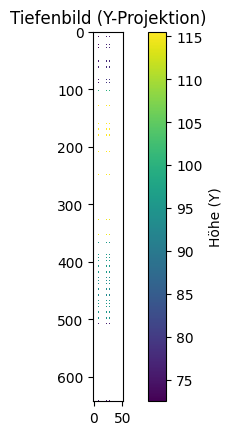

In [ ]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

# 1. VoxelGrid aus deinem Mesh
voxel_size = 0.1
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=voxel_size)

# 2. Alle Voxel-Zentren extrahieren
voxels = voxel_grid.get_voxels()
centers = np.array([voxel.grid_index for voxel in voxels])  # in Voxel-Grid-Koordinaten
centers = centers.astype(float) * voxel_size + voxel_grid.origin  # in Weltkoordinaten

# 3. (X,Z)-Paare → höchstes Y (also Y-Maximum je (X,Z))
# Runde X und Z auf Gitterauflösung
xz = np.round(centers[:, [0, 2]] / voxel_size).astype(int)
y = centers[:, 1]  # Y-Höhen

# Dictionary: (X,Z) -> max(Y)
height_map = {}
for i in range(len(xz)):
    key = tuple(xz[i])
    if key not in height_map or y[i] > height_map[key]:
        height_map[key] = y[i]

# 4. In 2D-Bild umwandeln
keys = np.array(list(height_map.keys()))
values = np.array(list(height_map.values()))

# Koordinaten normalisieren auf (0, ..., W-1), (0, ..., H-1)
min_xz = keys.min(axis=0)
max_xz = keys.max(axis=0)
size_xz = max_xz - min_xz + 1

img = np.full((size_xz[1], size_xz[0]), fill_value=np.nan)  # (H, W) = (Z, X)

for (k, v) in zip(keys, values):
    x_idx = k[0] - min_xz[0]
    z_idx = k[1] - min_xz[1]
    img[z_idx, x_idx] = v  # Tiefe in Y

# 6. Anzeigen
plt.imshow(img, cmap='viridis')
plt.title("Tiefenbild (Y-Projektion)")
plt.colorbar(label='Höhe (Y)')
plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_6572\60042418.py:20: RuntimeWarning: invalid value encountered in cast
  sobel_combined = np.uint8(255 * sobel_combined / np.max(sobel_combined))


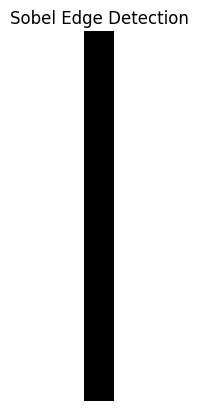

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Angenommen, 'img' ist dein NumPy-Array (ein Graustufenbild)
# Falls dein Bild farbig ist, kannst du es vorher in Graustufen umwandeln:
# img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = img  # wenn schon Graustufen

# Sobel in x-Richtung
sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)

# Sobel in y-Richtung
sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)

# Betrag des Gradienten berechnen
sobel_combined = np.sqrt(sobelx**2 + sobely**2)

# Optional: Normieren auf 0-255 und in uint8 konvertieren
sobel_combined = np.uint8(255 * sobel_combined / np.max(sobel_combined))

# Ergebnis anzeigen
plt.imshow(sobel_combined, cmap='gray')
plt.title('Sobel Edge Detection')
plt.axis('off')
plt.show()

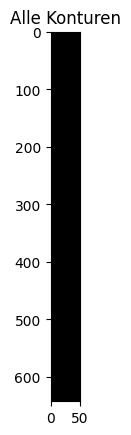

In [ ]:
# 'edges' ist dein Kantenbild (binary, uint8)
contours, hierarchy = cv2.findContours(sobel_combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Leeres schwarzes Bild mit gleicher Größe wie edges
contour_img = np.zeros_like(sobel_combined)

# Alle Konturen zeichnen, weiß (255), Dicke 2
cv2.drawContours(contour_img, contours, -1, color=255, thickness=2)

plt.imshow(contour_img, cmap='gray')
plt.title('Alle Konturen')
plt.show()

In [ ]:
point = (80, 50)  # Koordinaten des Pixels, z.B. (50, 100)

for cnt in contours:
    # testet, ob point in der Kontur liegt (>0 = innen, 0 = auf der Kontur, <0 = außen)
    if cv2.pointPolygonTest(cnt, point, False) >= 0:
        # Gefundene Kammer (Kontur), die den Punkt enthält
        target_contour = cnt
        break



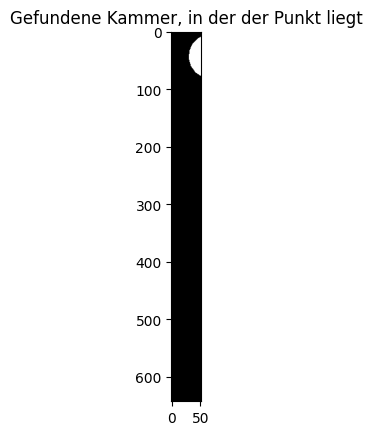

In [ ]:
# Leere Maske erstellen
mask = np.zeros_like(sobel_combined)

# Gefundene Kontur auf der Maske füllen (weiß)
cv2.drawContours(mask, [target_contour], -1, color=255, thickness=-1)

# Ergebnis anzeigen
plt.imshow(mask, cmap='gray')
plt.title('Gefundene Kammer, in der der Punkt liegt')
plt.show()